In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

# Project description
### About dataset
In this project we have dataset related to red wine, and our goal is to predict the quality rating of each wine. There are twelve features, and due to privacy issue, our dataset only contain the physicochemical tests and sensory rating, without price, country of origin, brand, etc. The quality rating integer is between zero to ten, but our dataset only contain the range of three to eight. 

### Why this problem
In real life, wine rating is money costing. We need to hire sommeliers, and good sommeliers are not easy to hire. So, we want to use machine learning predict the quality. Also, wine rating only dependent on human sensory, we want to know how the rate relates to the physicochemical factors.

### What I will do in this project
This problem can be treat as regression or classification problem. The dataset had been Well cleaned, so I will focus on understanding each features, finding the useful features, and tring different method, like normalization, remove outlier and compare how those method affect the accuray. 

## Read and check the data
We will read the csv and inspect the data. We check the first few rows of data and get a rough idea of how the data look like. Then we will check how many null value we have, it will be helpful for doing the cleaning next step.

In [2]:
red_df = pd.read_csv('wine_data/winequality-red.csv', sep = ';')

red_df.columns = red_df.columns.str.replace(" ","_")
red_df.info()
print(red_df.head())
red_x = red_df.iloc[:,:-1]
red_y = red_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(red_x, red_y, test_size=0.3, random_state=1599,stratify=red_y)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00 

## Rough model
Because the data had been clean up, we can do a model to see how well is the data. Then we will have normalization, discard the less important feautre, and try more model next. This model can be use as a comparrson to see how those methods help improve the accuracy.

In [3]:
lreg = LinearRegression().fit(x_train, y_train)
print(f'Regression:   The accuracy for train {lreg.score(x_train,y_train):.4f} , test {lreg.score(x_test,y_test):.4f}, cross val: {np.mean(cross_val_score(lreg, red_x, red_y, cv=5)):.4f}')

adb = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
adb.fit(x_train, y_train)
print(f'AdaBoost:     The accuracy for train {adb.score(x_train,y_train):.4f} , test {adb.score(x_test,y_test):.4f}, cross val: {np.mean(cross_val_score(adb, red_x, red_y, cv=5)):.4f}')

rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(x_train, y_train)
print(f'RandomForest: The accuracy for train {rf.score(x_train,y_train):.4f} , test {rf.score(x_test,y_test):.4f}, cross val: {np.mean(cross_val_score(rf, red_x, red_y, cv=5)):.4f}')

linear_svm = SVC(C = 1, kernel = 'linear')
linear_svm.fit(x_train, y_train)
print(f'Linear svm:   The accuracy for train {linear_svm.score(x_train,y_train):.4f} , test {linear_svm.score(x_test,y_test):.4f}, cross val: {np.mean(cross_val_score(linear_svm, red_x, red_y, cv=5)):.4f}')

rbf_svm = SVC(C = 1, kernel = 'rbf', gamma = 1)
rbf_svm.fit(x_train, y_train)
print(f'rbf svm:      The accuracy for train {rbf_svm.score(x_train,y_train):.4f} , test {rbf_svm.score(x_test,y_test):.4f}, cross val: {np.mean(cross_val_score(rbf_svm, red_x, red_y, cv=5)):.4f}')

print('confusion matrix for SVM')
confusion_matrix(y_test, rbf_svm.predict(x_test))


Regression:   The accuracy for train 0.3450 , test 0.3934, cross val: 0.2900
AdaBoost:     The accuracy for train 0.5112 , test 0.5250, cross val: 0.5078
RandomForest: The accuracy for train 0.5818 , test 0.5563, cross val: 0.5610
Linear svm:   The accuracy for train 0.5925 , test 0.5813, cross val: 0.5716
rbf svm:      The accuracy for train 0.9821 , test 0.5917, cross val: 0.4515
confusion matrix for SVM


array([[  0,   0,   2,   1,   0,   0],
       [  0,   0,  13,   3,   0,   0],
       [  0,   0, 180,  24,   0,   0],
       [  0,   0, 103,  88,   1,   0],
       [  0,   0,  33,  12,  15,   0],
       [  0,   0,   3,   1,   0,   1]], dtype=int64)

From the result above, we can see the accuracy is really bad, if we using raw data. So we will some methods to improve our result.

## Pairplot without target
We can find correlation between features from pairplot

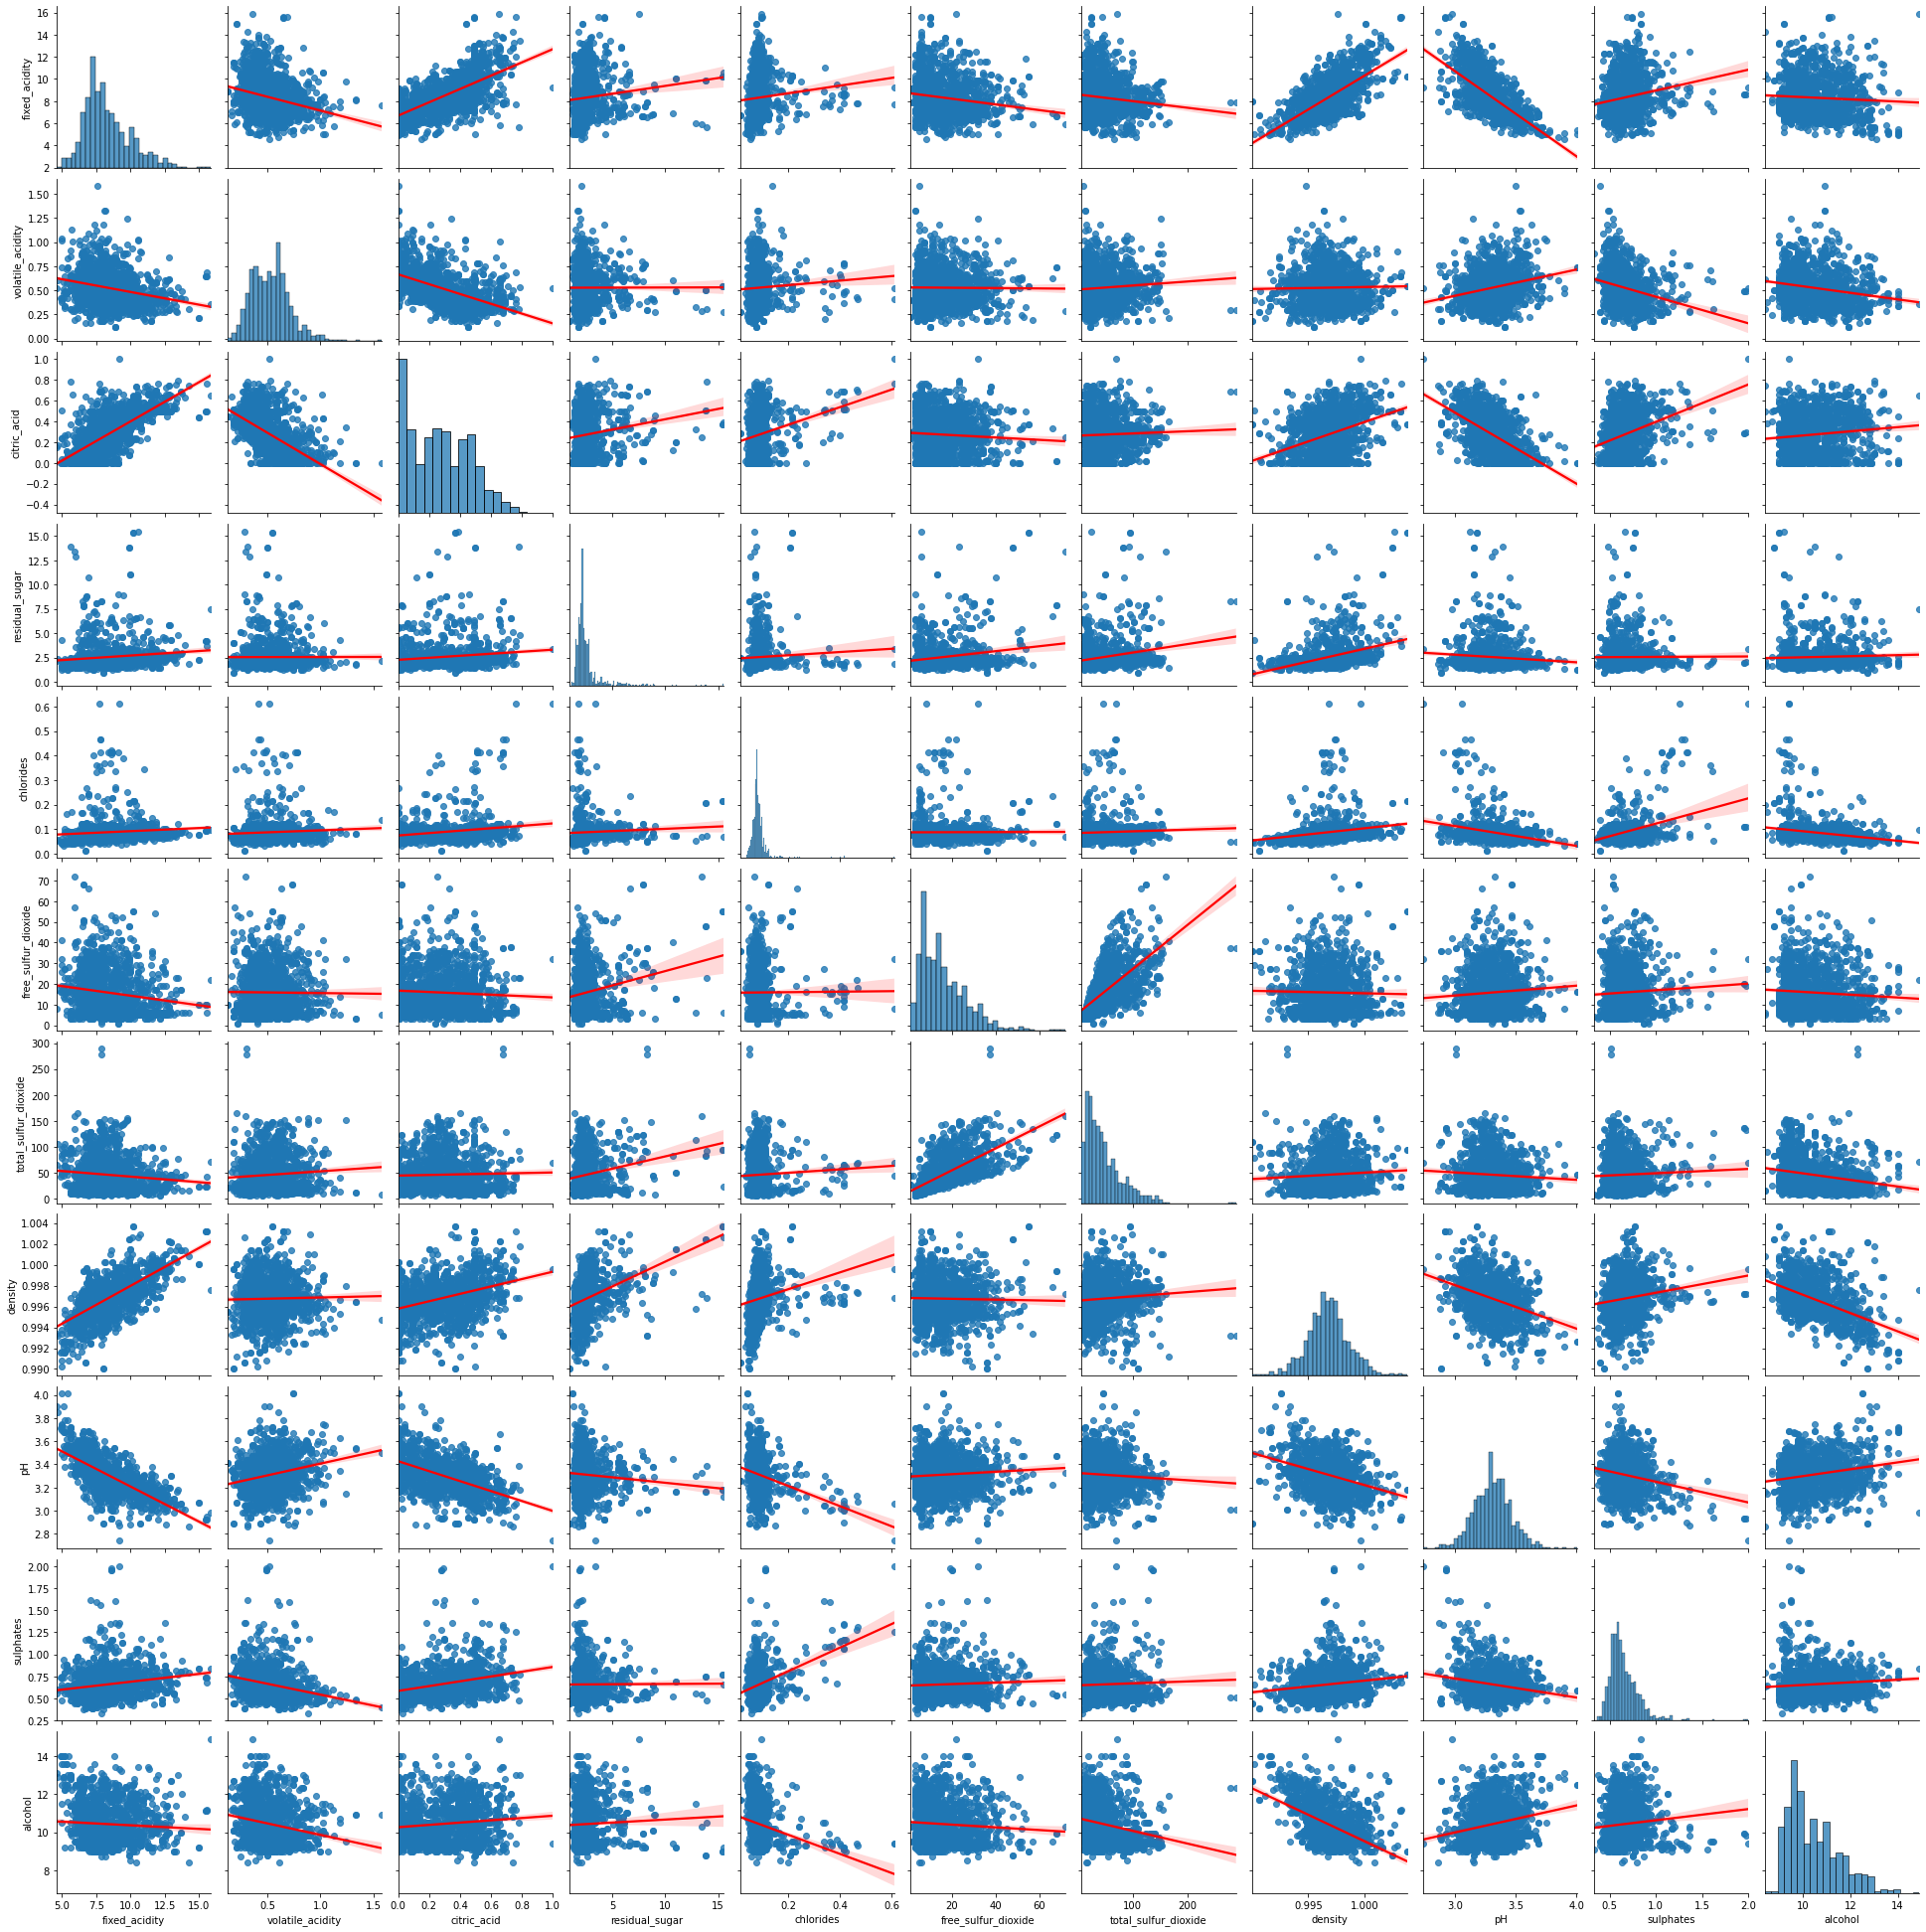

In [4]:
# relation between each feature
sns.pairplot(red_x, kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()

## Relation between each feature


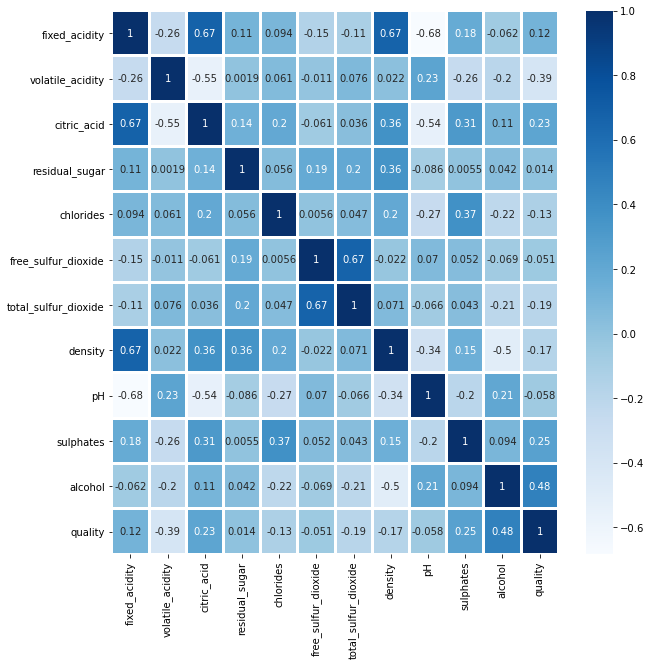

In [5]:
corr = red_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax1 = sns.heatmap(corr, linewidths=2, cmap='Blues', annot=True)
plt.show()

## Min-max, Box-plot, Histogram
we find the outlier by box-plot and check the distribution by histogram.

       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

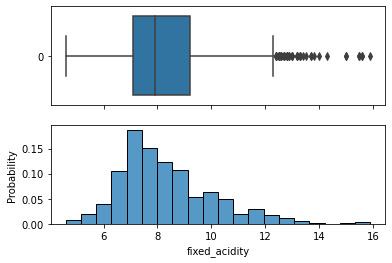

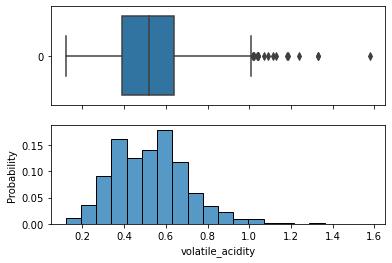

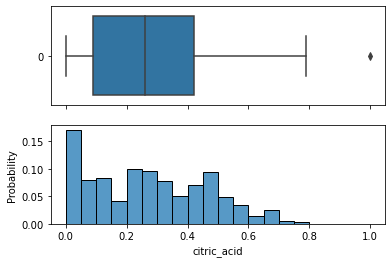

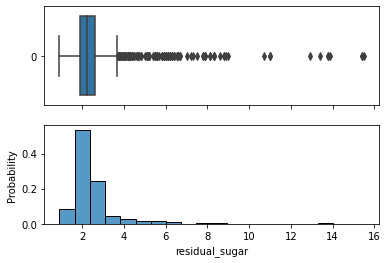

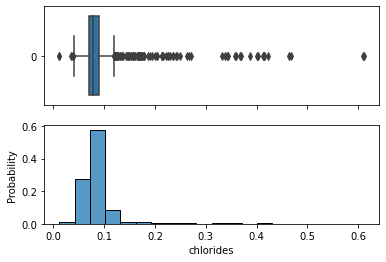

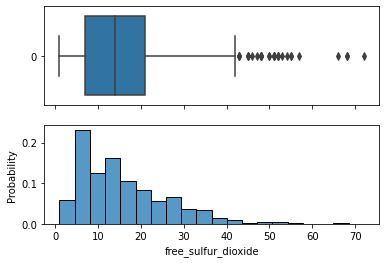

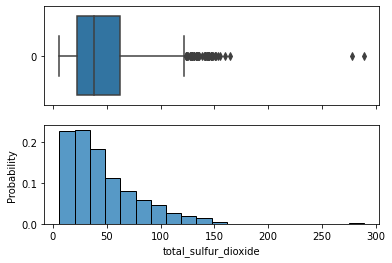

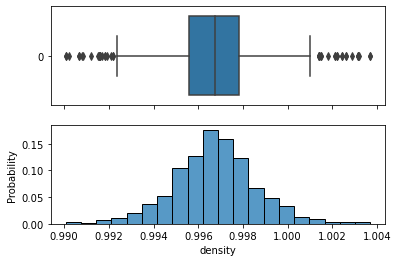

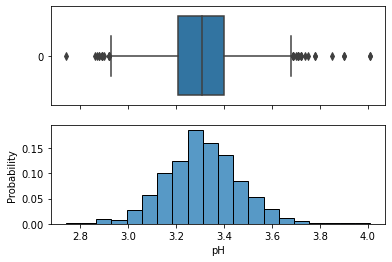

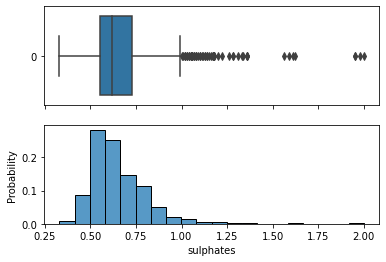

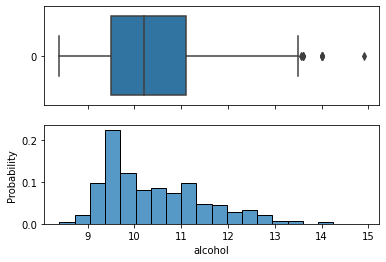

In [6]:
print(red_x.describe())

for i in red_x:
    _, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    sns.boxplot(data = red_x[i], ax = ax_box, orient="h")
    sns.histplot(data = red_x[i], ax = ax_hist, stat = 'probability', bins = 20)
    ax_box.set(xlabel='')
    plt.show()

According to the boxplots and histograms above, we can see that there are a lot of outliers, and in some features, like chlorides and residual sugar, the outliers are very extreme. 

## Distribution of target variable

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64


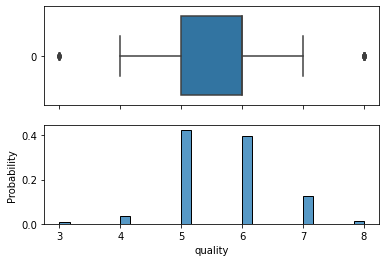

value counts
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


In [7]:
print(red_y.describe())
_, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
sns.boxplot(data = red_y, ax = ax_box, orient="h")
sns.histplot(data = red_y, ax = ax_hist, stat = 'probability')
ax_box.set(xlabel='')
plt.show()

print("value counts")
print(red_y.value_counts())

The labels are very uneven, so we should not use cross validation, because randomly choosing may cause the train or test dataset lack of certain rare labels, and cause the model performance worse.

## Oversampling
From the target distribution and the confusion matrix above, we can see the target sample are imbalance, this will cause the model does not learning the pattern of minority, and hard to distinguish with the majority. The confusion matrix shows model have a low accuracy of minority. Therefore, we will do oversampling, so the model can learn more about minority.

In [8]:
ros = RandomOverSampler(random_state=0)
ros.fit(red_x, red_y)
oversamp_x, oversamp_y = ros.fit_resample(red_x, red_y)
x_over_train, x_over_test, y_over_train, y_over_test = train_test_split(oversamp_x, oversamp_y, test_size=0.3, random_state=1599, stratify=oversamp_y)

rbf_svm = SVC(C = 1, kernel = 'rbf', gamma = 1)
rbf_svm.fit(x_train, y_train)
print(f'rbf svm:      The accuracy for train is {rbf_svm.score(x_over_train,y_over_train):.4f} , for test is {rbf_svm.score(x_over_test,y_over_test):.4f}')
print(f'cross validation: {np.mean(cross_val_score(rbf_svm, oversamp_x, oversamp_y, cv=3)):.4f}')

rbf svm:      The accuracy for train is 0.7210 , for test is 0.7325
cross validation: 0.8475


Doing oversampling, the accuracy is greatly improved, from .59 to .84, and that is how others doing on kaggle. But, are we doing correctly? What about switching the order, instead of doing the train_test_split after oversmapling, let's split is at first then overampling, and see what will happen.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(red_x, red_y, test_size=0.3, random_state=1599,stratify=red_y)
ros = RandomOverSampler(random_state=0)
ros.fit(x_train, y_train)
oversamp_x_after_split, oversamp_y_after_split = ros.fit_resample(x_train, y_train)
                                          
rbf_svm = SVC(C = 1, kernel = 'rbf', gamma = 1)
rbf_svm.fit(x_train, y_train)
print(f'rbf svm:      The accuracy for train is {rbf_svm.score(oversamp_x_after_split, oversamp_y_after_split):.4f} , for test is {rbf_svm.score(x_test,y_test):.4f}')

rbf svm:      The accuracy for train is 0.9168 , for test is 0.5917


We can see the accuracy is almost the same as not doing oversmapling. We will inpect the train and test data that split after the oversampling and figure out the reason.

In [10]:
train_8 = y_over_train[y_over_train == 8].index
x_over_train_8 = x_over_train.loc[train_8]
print("Feature for training data with label 8")
print(x_over_train_8.head())

test_8 = y_over_test[y_over_test == 8].index
x_over_test_8 = x_over_test.loc[test_8]
print('Feature for testing data with label 8')
print(x_over_test_8.head())

Feature for training data with label 8
      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
3759           10.7              0.35         0.53             2.6      0.070   
3610            5.5              0.49         0.03             1.8      0.044   
3736           12.6              0.31         0.72             2.2      0.072   
3972            7.9              0.54         0.34             2.5      0.076   
4042            5.0              0.42         0.24             2.0      0.060   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
3759                  5.0                  16.0  0.99720  3.15       0.65   
3610                 28.0                  87.0  0.99080  3.50       0.82   
3736                  6.0                  29.0  0.99870  2.88       0.82   
3972                  8.0                  17.0  0.99235  3.20       0.72   
4042                 19.0                  50.0  0.99170  3.72       0.74   

      alcoh

We can see 3759 and 3533, 4042 and 3874, their index are different, and one from training and the other from testing, but they are identical. If we split the data after oversampling, the training data may contain testing data. that is why we get a high accuracy. Oversampling randomly duplicate example in the minority class, so we should split train test data before oversampling. It means oversmapling does help much in our case.

## Find the most important feature
Here, we will use the SelectKBest from sklearn to find which feature is important. Then we will use the forward selection to see how features affect the accuracy. Also we will use the linear regression for each feature and inspect rsquare score.

In [11]:
from sklearn.feature_selection import SelectKBest,chi2
bf = SelectKBest(score_func=chi2, k=11).fit(red_x, red_y)
score = pd.DataFrame(bf.scores_)
column_name = pd.DataFrame(red_x.columns)
best_feature = pd.concat([column_name, score], axis='columns')
best_feature.columns = ['feature','score']
print(f'Using SelectKBest ')
print(best_feature.sort_values(by=['score'], ascending=False))

# using ols 
rsq = []
for p in red_x.columns:
    model  = smf.ols(formula = "quality ~ "+p,data = red_df).fit()
    rsq.append(model.rsquared)
    
feature_rsquared = pd.concat([column_name, pd.DataFrame(rsq)], axis='columns')
feature_rsquared.columns = ['feature','rsquared']
print(f'Using rsquared ')
print(feature_rsquared.sort_values(by=['rsquared'], ascending=False))

Using SelectKBest 
                 feature        score
6   total_sulfur_dioxide  2755.557984
5    free_sulfur_dioxide   161.936036
10               alcohol    46.429892
1       volatile_acidity    15.580289
2            citric_acid    13.025665
0          fixed_acidity    11.260652
9              sulphates     4.558488
3         residual_sugar     4.123295
4              chlorides     0.752426
8                     pH     0.154655
7                density     0.000230
Using rsquared 
                 feature  rsquared
10               alcohol  0.226734
1       volatile_acidity  0.152535
9              sulphates  0.063200
2            citric_acid  0.051245
6   total_sulfur_dioxide  0.034262
7                density  0.030597
4              chlorides  0.016617
0          fixed_acidity  0.015389
8                     pH  0.003333
5    free_sulfur_dioxide  0.002566
3         residual_sugar  0.000189


The above show which feature affect the prediction the most, and their results are very different. In the next cell we will try  forward selection for each situation, and see which method is more reliable

## Forward selection

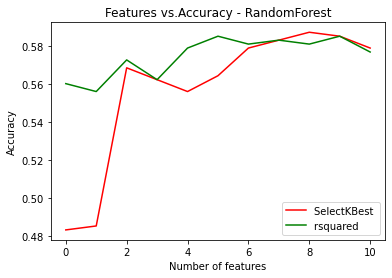

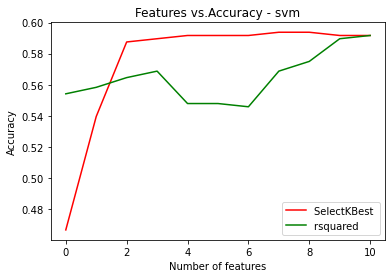

In [12]:
skb = best_feature.sort_values(by=['score'], ascending=False)
rsq = feature_rsquared.sort_values(by=['rsquared'], ascending=False)

rf = RandomForestClassifier(max_depth=2, random_state=0)
rbf_svm = SVC(C = 1, kernel = 'rbf', gamma = 1)

skb_rf = []
skb_svm = []
skb_feature = []
rsq_rf = []
rsq_svm = []
rsq_feature = []

for i in skb['feature']:
    skb_feature.append(i)
    rf.fit(x_train[skb_feature], y_train)
    rbf_svm.fit(x_train[skb_feature], y_train)
    skb_rf.append(rf.score(x_test[skb_feature], y_test))
    skb_svm.append(rbf_svm.score(x_test[skb_feature], y_test))

for i in rsq['feature']:
    rsq_feature.append(i)
    rf.fit(x_train[rsq_feature], y_train)
    rbf_svm.fit(x_train[rsq_feature], y_train)
    rsq_rf.append(rf.score(x_test[rsq_feature], y_test))
    rsq_svm.append(rbf_svm.score(x_test[rsq_feature], y_test))

plt.plot(range(11), skb_rf, color='r', label='SelectKBest ')
plt.plot(range(11), rsq_rf, color='g', label='rsquared ')
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Features vs.Accuracy - RandomForest")
plt.legend()
plt.show()

plt.plot(range(11), skb_svm, color='r', label='SelectKBest ')
plt.plot(range(11), rsq_svm, color='g', label='rsquared ')
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Features vs.Accuracy - svm")
plt.legend()
plt.show()

Reducing the feature make the models work poor. Also, we only have 12 features, which are not much, we should keep them all.

## Remove outliers
In normal case, Discarding those cases can improve our model. However, in our data, we may not do that. Sometimes, wine can be rated as a high quality because of a very prominent feature, those outliers maybe helpful for high quality wine. To confirm my thought, We will discard those outliers and see how it affect the accuracy in general and accuracy for each quality.

We only apply removeing outliers here, 

In [22]:
outliers_list = []
outliers_number = []
for feature in red_x.columns:
    lower = red_x[feature].quantile(0.02)
    higher = red_x[feature].quantile(0.98)
        
    outliers_index = red_x[(red_x[feature] > higher) | (red_x[feature] < lower)].index
    outliers_list.append(outliers_index)
    outliers_number.append(len(outliers_index))
    
total_outliers = set()
for i in outliers_list:
    total_outliers = total_outliers.union(set(i))
print(f'Total number of outliers: {len(total_outliers)}')

feature_outliers = pd.concat([pd.DataFrame(red_x.columns), pd.DataFrame(outliers_number)], axis='columns')
feature_outliers.columns = ['feature','outliers']

adb = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
rf = RandomForestClassifier(max_depth=2, random_state=0)
rbf_svm = SVC(C = 1, kernel = 'rbf', gamma = 1)

no_outlier_x = red_x.loc[list(set(red_x.index) - total_outliers)]
no_outlier_y = red_y.loc[list(set(red_y.index) - total_outliers)]
print(f'Adaboosting with no outliers in cross val: {np.mean(cross_val_score(adb, no_outlier_x, no_outlier_y, cv=3)):.4f}')
print(f'Random forest with no outliers in cross val: {np.mean(cross_val_score(rf, no_outlier_x, no_outlier_y, cv=3)):.4f}')
print(f'Svm with no outliers in cross val: {np.mean(cross_val_score(rbf_svm, no_outlier_x, no_outlier_y, cv=3)):.4f}')

Total number of outliers: 361
Adaboosting with no outliers in cross val: 0.5452
Random forest with no outliers in cross val: 0.5679
Svm with no outliers in cross val: 0.4572


In [14]:
outlier_y = red_y.loc[list(total_outliers)]
print("Counting the label of remove outliers")
print(outlier_y.value_counts())
print("Outliers in percentage")
print(outlier_y.value_counts()/red_y.value_counts())

Counting the label of remove outliers
5    143
6    135
7     54
4     16
8      7
3      6
Name: quality, dtype: int64
Outliers in percentage
5    0.209985
6    0.211599
7    0.271357
4    0.301887
8    0.388889
3    0.600000
Name: quality, dtype: float64


We can see that the outliers do not evenly distribute. Their are mainly describe the high and low quality wine, if we remove them, it affect our performence

## Normalization
The range for each features are variance, like sulfur dioxide, having a wide range from 1 to 50, even without outlier, others like density, from 0.99 to 1. Some models, like svm and regression, are senstive to the scale. Normalization can rescale our features and improve the accuracy, here, we will do two kinds of normalization and compare their result.

In [15]:
# minmax normalization
minmax = MinMaxScaler()
minmax.fit(red_x)
minmax_x = minmax.fit_transform(red_x)
minmax_x = pd.DataFrame(minmax_x, columns=red_x.columns)

adb = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
rf = RandomForestClassifier(max_depth=2, random_state=0)
rbf_svm = SVC(C = 1, kernel = 'rbf', gamma = 1)

train_x_norm, test_x_norm,train_y,test_y = train_test_split(minmax_x, red_y,test_size = 0.2,stratify=red_y)

print('MinMax Normalization')
rbf_svm.fit(train_x_norm, train_y)
print(f'rbf svm:      The accuracy for train is {rbf_svm.score(train_x_norm,train_y):.4f} , for test is {rbf_svm.score(test_x_norm,test_y):.4f}')

adb.fit(train_x_norm, train_y)
print(f'AdaBoost:     The accuracy for train is {adb.score(train_x_norm,train_y):.4f} , for test is {adb.score(test_x_norm,test_y):.4f}')

rf.fit(train_x_norm, train_y)
print(f'RandomForest: The accuracy for train is {rf.score(train_x_norm,train_y):.4f} , for test is {rf.score(test_x_norm,test_y):.4f}')

poly_svm = SVC(C = 1, kernel = 'poly', degree = 5, gamma = 1 )
poly_svm.fit(train_x_norm, train_y)
print(f'poly d=5 svm: The accuracy for train is {poly_svm.score(train_x_norm, train_y):.4f} , for test is {poly_svm.score(test_x_norm,test_y):.4f}')


MinMax Normalization
rbf svm:      The accuracy for train is 0.6067 , for test is 0.5500
AdaBoost:     The accuracy for train is 0.5606 , for test is 0.5125
RandomForest: The accuracy for train is 0.5864 , for test is 0.5656
poly d=5 svm: The accuracy for train is 0.6458 , for test is 0.5719


In [16]:
# standard normalization
ss = StandardScaler()
norm_x = ss.fit_transform(red_x)
train_x_norm, test_x_norm,train_y,test_y = train_test_split(norm_x, red_y,test_size = 0.2,stratify=red_y)

adb = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
rf = RandomForestClassifier(max_depth=2, random_state=0)
rbf_svm = SVC(C = 1, kernel = 'rbf', gamma = 1)

print('standard normalization')
rbf_svm.fit(train_x_norm, train_y)
print(f'rbf svm:      The accuracy for train is {rbf_svm.score(train_x_norm,train_y):.4f} , for test is {rbf_svm.score(test_x_norm,test_y):.4f}')

adb.fit(train_x_norm, train_y)
print(f'AdaBoost:     The accuracy for train is {adb.score(train_x_norm,train_y):.4f} , for test is {adb.score(test_x_norm,test_y):.4f}')

rf.fit(train_x_norm, train_y)
print(f'RandomForest: The accuracy for train is {rf.score(train_x_norm,train_y):.4f} , for test is {rf.score(test_x_norm,test_y):.4f}')

poly_svm = SVC(C = 1, kernel = 'poly', degree = 5, gamma = 1 )
poly_svm.fit(train_x_norm, train_y)
print(f'poly d=5 svm: The accuracy for train is {poly_svm.score(train_x_norm, train_y):.4f} , for test is {poly_svm.score(test_x_norm,test_y):.4f}')


standard normalization
rbf svm:      The accuracy for train is 0.9304 , for test is 0.6750
AdaBoost:     The accuracy for train is 0.5434 , for test is 0.5312
RandomForest: The accuracy for train is 0.5817 , for test is 0.5750
poly d=5 svm: The accuracy for train is 1.0000 , for test is 0.6000


## SearchGrid

In [17]:
'''
Those functions are directly from assignment 6, they are for better visualization of GridSearchCV.
'''
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

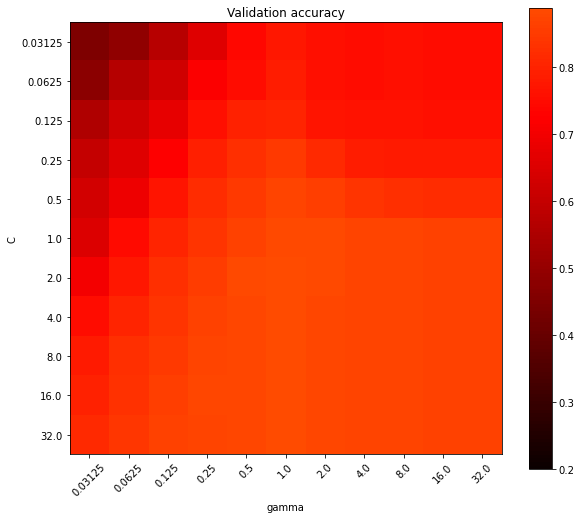

{'C': 2.0, 'gamma': 1.0, 'kernel': 'rbf'}


In [18]:
grid = GridSearchCV(estimator = SVC(), param_grid = {'C': np.logspace(-5, 5, num=11, base = 2),'kernel': ['rbf'],
                                                     'gamma': np.logspace(-5, 5, num=11, base = 2)}, cv = 3)

ss = StandardScaler()
norm_x = ss.fit_transform(red_x)
#train_x_norm, test_x_norm,train_y,test_y = train_test_split(norm_x, red_y,test_size = 0.2,stratify=red_y)

x_train, x_test, y_train, y_test = train_test_split(norm_x, red_y, test_size=0.3, random_state=1599,stratify=red_y)
ros = RandomOverSampler(random_state=0)
ros.fit(x_train, y_train)
x_train, y_train = ros.fit_resample(x_train, y_train)

grid.fit(x_train, y_train)
plotSearchGrid(grid)
print(grid.best_params_)

## Final result

In [19]:
# train model
rbf_svm = SVC(C = 2, kernel = 'rbf', gamma = 1)
rbf_svm.fit(x_train, y_train)

# result
print(f'rbf svm:      The accuracy for train is {rbf_svm.score(x_train, y_train):.4f} , for test is {rbf_svm.score(x_test,y_test):.4f}')
print(f'cross validation: {np.mean(cross_val_score(rbf_svm, norm_x, red_y, cv=5)):.4f}')
print('confusion matrix for SVM')
confusion_matrix(test_y, rbf_svm.predict(test_x_norm))


rbf svm:      The accuracy for train is 0.9941 , for test is 0.6729
cross validation: 0.5172
confusion matrix for SVM


array([[  2,   0,   0,   0,   0,   0],
       [  0,   9,   2,   0,   0,   0],
       [  0,   0, 131,   4,   1,   0],
       [  0,   0,  12, 114,   2,   0],
       [  0,   0,   3,   6,  31,   0],
       [  0,   0,   0,   0,   0,   3]], dtype=int64)

## Compare features' distribution of quality 5 and quality 6
As we see the confusion matrix above, no matter how we modify our data, the accuracy does get much improvement, and the error is mostly about predicting quality 5 to 6, and predicting quality 6 to 5 and 7. Models have a hard time to distinguish between 5 and 6, we will look closely at each feature of quality 5 and 6.

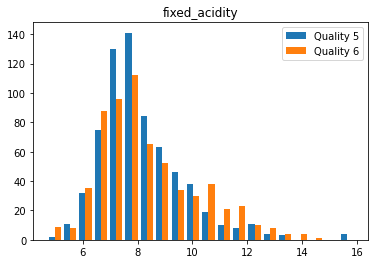

        Quality 5   Quality 6
count  681.000000  638.000000
mean     8.167254    8.347179
std      1.563988    1.797849
min      5.000000    4.700000
25%      7.100000    7.000000
50%      7.800000    7.900000
75%      8.900000    9.400000
max     15.900000   14.300000


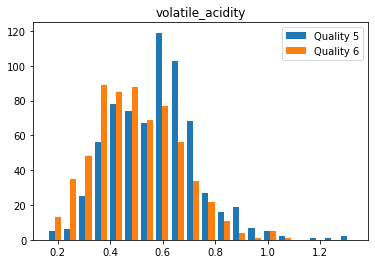

        Quality 5   Quality 6
count  681.000000  638.000000
mean     0.577041    0.497484
std      0.164801    0.160962
min      0.180000    0.160000
25%      0.460000    0.380000
50%      0.580000    0.490000
75%      0.670000    0.600000
max      1.330000    1.040000


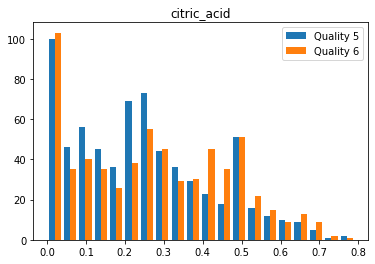

        Quality 5   Quality 6
count  681.000000  638.000000
mean     0.243686    0.273824
std      0.180003    0.195108
min      0.000000    0.000000
25%      0.090000    0.090000
50%      0.230000    0.260000
75%      0.360000    0.430000
max      0.790000    0.780000


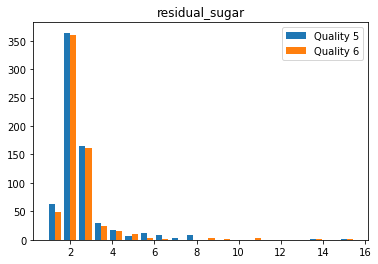

        Quality 5   Quality 6
count  681.000000  638.000000
mean     2.528855    2.477194
std      1.359753    1.441576
min      1.200000    0.900000
25%      1.900000    1.900000
50%      2.200000    2.200000
75%      2.600000    2.500000
max     15.500000   15.400000


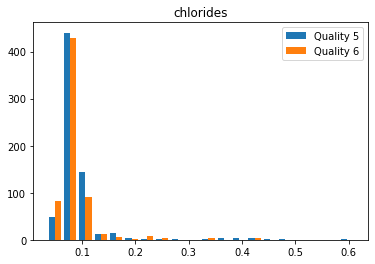

        Quality 5   Quality 6
count  681.000000  638.000000
mean     0.092736    0.084956
std      0.053707    0.039563
min      0.039000    0.034000
25%      0.074000    0.068250
50%      0.081000    0.078000
75%      0.094000    0.088000
max      0.611000    0.415000


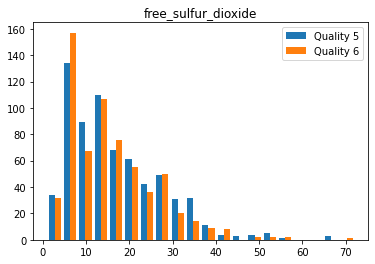

        Quality 5   Quality 6
count  681.000000  638.000000
mean    16.983847   15.711599
std     10.955446    9.940911
min      3.000000    1.000000
25%      9.000000    8.000000
50%     15.000000   14.000000
75%     23.000000   21.000000
max     68.000000   72.000000


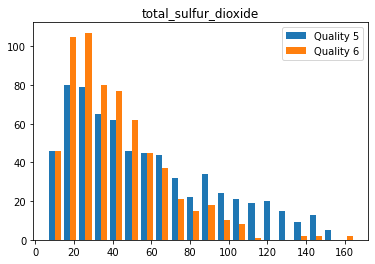

        Quality 5   Quality 6
count  681.000000  638.000000
mean    56.513950   40.869906
std     36.993116   25.038250
min      6.000000    6.000000
25%     26.000000   23.000000
50%     47.000000   35.000000
75%     84.000000   54.000000
max    155.000000  165.000000


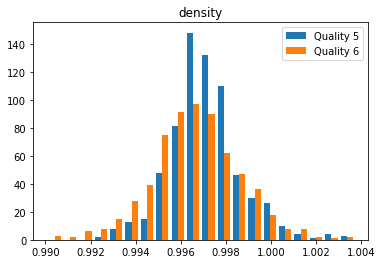

        Quality 5   Quality 6
count  681.000000  638.000000
mean     0.997104    0.996615
std      0.001589    0.002000
min      0.992560    0.990070
25%      0.996200    0.995402
50%      0.997000    0.996560
75%      0.997900    0.997893
max      1.003150    1.003690


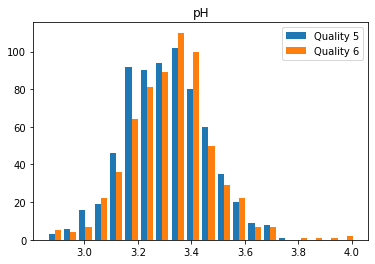

        Quality 5   Quality 6
count  681.000000  638.000000
mean     3.304949    3.318072
std      0.150618    0.153995
min      2.880000    2.860000
25%      3.200000    3.220000
50%      3.300000    3.320000
75%      3.400000    3.410000
max      3.740000    4.010000


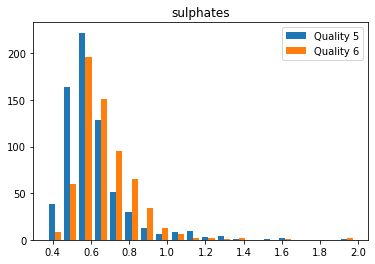

        Quality 5   Quality 6
count  681.000000  638.000000
mean     0.620969    0.675329
std      0.171062    0.158650
min      0.370000    0.400000
25%      0.530000    0.580000
50%      0.580000    0.640000
75%      0.660000    0.750000
max      1.980000    1.950000


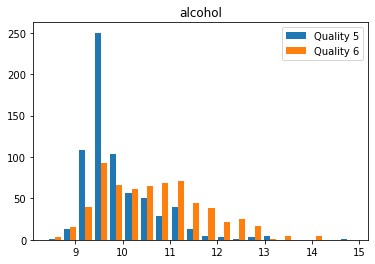

        Quality 5   Quality 6
count  681.000000  638.000000
mean     9.899706   10.629519
std      0.736521    1.049639
min      8.500000    8.400000
25%      9.400000    9.800000
50%      9.700000   10.500000
75%     10.200000   11.300000
max     14.900000   14.000000


In [20]:
df_5 = red_df[red_df['quality'] == 5]
df_6 = red_df[red_df['quality'] == 6]

for i in red_df.columns[:-1]:
    plt.hist([df_5[i], df_6[i]], bins = 20, label=['Quality 5', 'Quality 6'])
    plt.legend()
    plt.title(i)
    plt.show()
    quality_df = pd.concat([df_5[i].describe(), df_6[i].describe()], axis='columns')
    quality_df.columns = ['Quality 5','Quality 6']
    print(quality_df)

## Changing target
The feature distribution of quality 5 and 6 are similar, which makes the model hard to distinguish between those two. Here, we can change our problem to a easy one. Instead of predicting the actually quality, we can predict the wine quality is bad or good, quality 6 or higher is consider good quality, it will make the problem easier. 

rbf svm:      The accuracy for train is 0.9859 , for test is 0.7688
confusion matrix
[[107  42]
 [ 32 139]]
SVM: ROC AUC=0.765


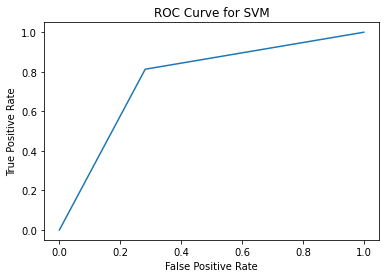

In [21]:
new_y_train = np.where(train_y>5, 1,0)
new_y_test = np.where(test_y>5, 1,0)

rbf_svm = SVC(C = 2, kernel = 'rbf', gamma = 1)
rbf_svm.fit(train_x_norm,new_y_train)
print(f'rbf svm:      The accuracy for train is {rbf_svm.score(train_x_norm,new_y_train):.4f} , for test is {rbf_svm.score(test_x_norm,new_y_test):.4f}')

print('confusion matrix')
print(confusion_matrix(new_y_test, rbf_svm.predict(test_x_norm)))

y_true = np.argmax(new_y_test, axis=0)
auc = roc_auc_score(new_y_test, rbf_svm.predict(test_x_norm))
print('SVM: ROC AUC=%.3f' % (auc))

ns_fpr, ns_tpr, _ = roc_curve(new_y_test, rbf_svm.predict(test_x_norm))
plt.plot(ns_fpr, ns_tpr)
plt.title('ROC Curve for SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Conclusion
For this dataset, we mainly focus on data modify and transformation. Normalization significantly improved to accuracy. Removing outliers and reducing features do not help, because we do not have much features, and outliers are important for highest and lowest quality. GridSearchCV find a good hyperparameter, but accuracy still not satisfactory. We look deeply at the distribution of each features, and find they are highly similar, it causes the model hard to learn the pattern. Finally, we  change the prbolem from multiclass classification to binary classification, and give us a better accurcay.

Future work of this dataset: To get better result, the author should collect more features, and collect more rare labels data.